## Sampling with Numerical SDE Solvers

In [1]:
# --- Jupyter Starter Pack ---

# autoreload: refresh code on every cell run
%reload_ext autoreload
%autoreload 2

# clean warnings
import warnings
warnings.filterwarnings("ignore")

# nicer printing
from pprint import pprint

# numpy / pandas nicer display
import numpy as np
np.set_printoptions(precision=4, suppress=True)

# matplotlib defaults
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# tqdm in notebooks
from tqdm.notebook import tqdm

# optional: make exceptions show only the important frame
%config InlineBackend.figure_format = "retina"

In [ ]:
from unet import UNetModel
from train_score import marginal_prob_std, diffusion_coeff
import functools
import torch 

device = 'cuda'
sigma =  25.0

cfg = {
	"model": {
		"in_channels": 1,
		"out_channels": 1,
		"model_channels": 32,
		"channel_mult": [1, 2, 4],
		"num_res_blocks": 1,
		"attention_resolutions": [],
		"max_period": 0.005,
	},
}

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)
UNet_model = UNetModel(marginal_prob_std=marginal_prob_std_fn, **cfg["model"])

score_model = UNet_model.to(device)
score_model.load_state_dict(torch.load('ckpt.pt', map_location=device))
score_model.eval()


<All keys matched successfully>

In [ ]:
import torch
num_steps =  500
def Euler_Maruyama_sampler(
  score_model,
  marginal_prob_std,
  diffusion_coeff,
  batch_size=64,
  num_steps=num_steps,
  device='cuda',
  eps=1e-3
):
	"""
	Generate samples from score-based models with the Euler-Maruyama solver.
	"""
	t = torch.ones(batch_size, device=device)
	init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
	* marginal_prob_std(t)[:, None, None, None]
	time_steps = torch.linspace(1., eps, num_steps, device=device)
	step_size = time_steps[0] - time_steps[1]
	x = init_x

	with torch.no_grad():
		for time_step in range(len(time_steps)):
			batch_time_step = torch.ones(batch_size, device=device) * time_steps[time_step]
			g = diffusion_coeff(batch_time_step)
			mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
			x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

	return mean_x

tensor(-0.0467, device='cuda:0') tensor(1.0400, device='cuda:0')


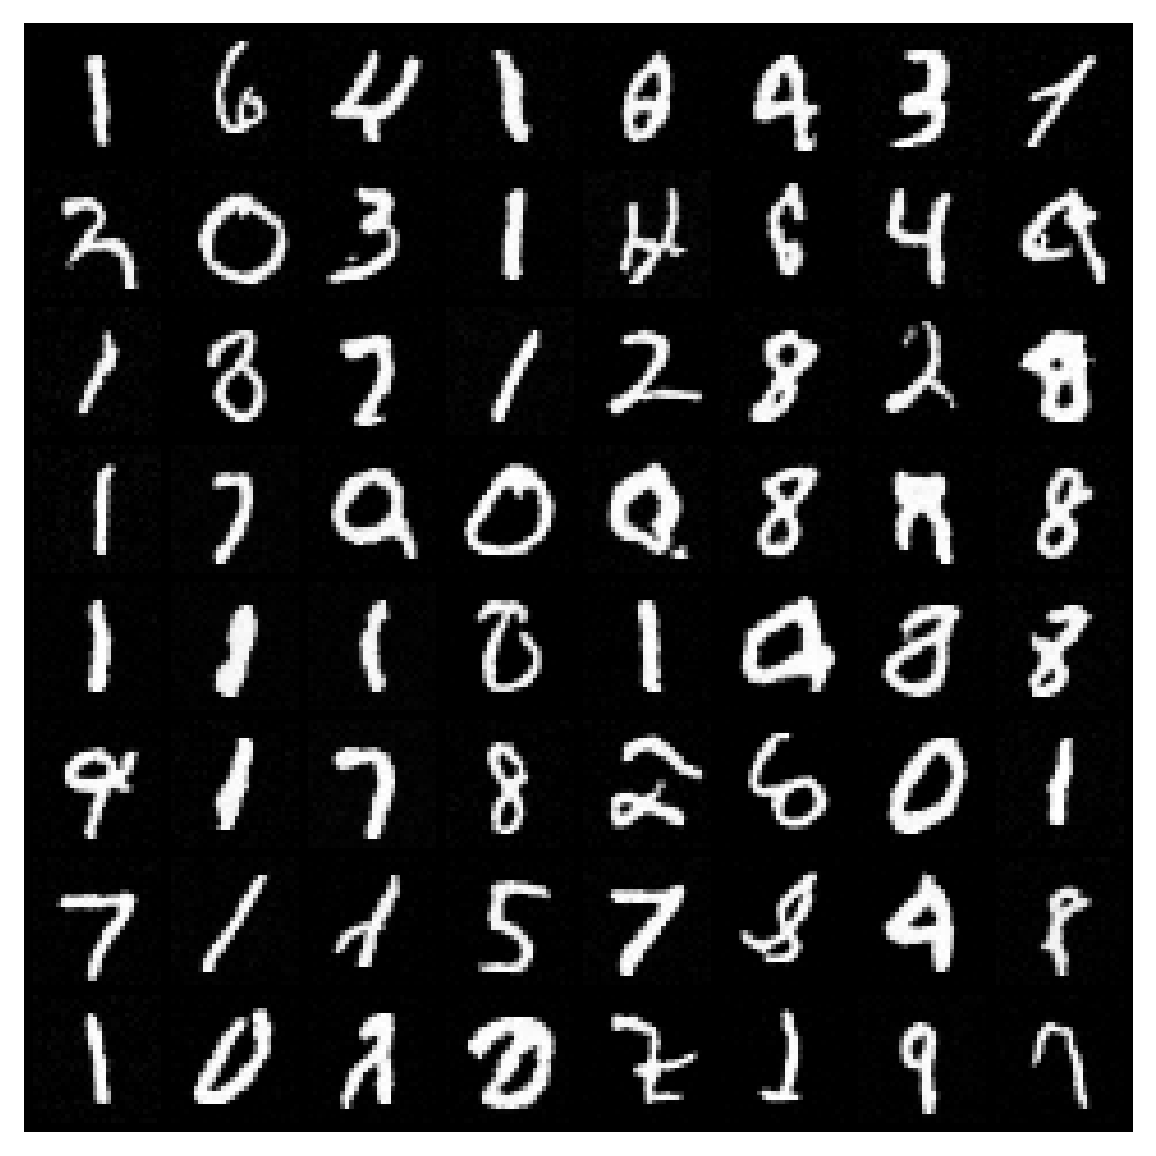

In [6]:
from torchvision.utils import make_grid
import numpy as np

device = 'cuda'
sample_batch_size = 64
sampler = Euler_Maruyama_sampler 

## Generate samples using the specified sampler.
samples = sampler(
    score_model,
    marginal_prob_std_fn,
    diffusion_coeff_fn,
    sample_batch_size,
    device=device
)

print(samples.min(), samples.max())
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

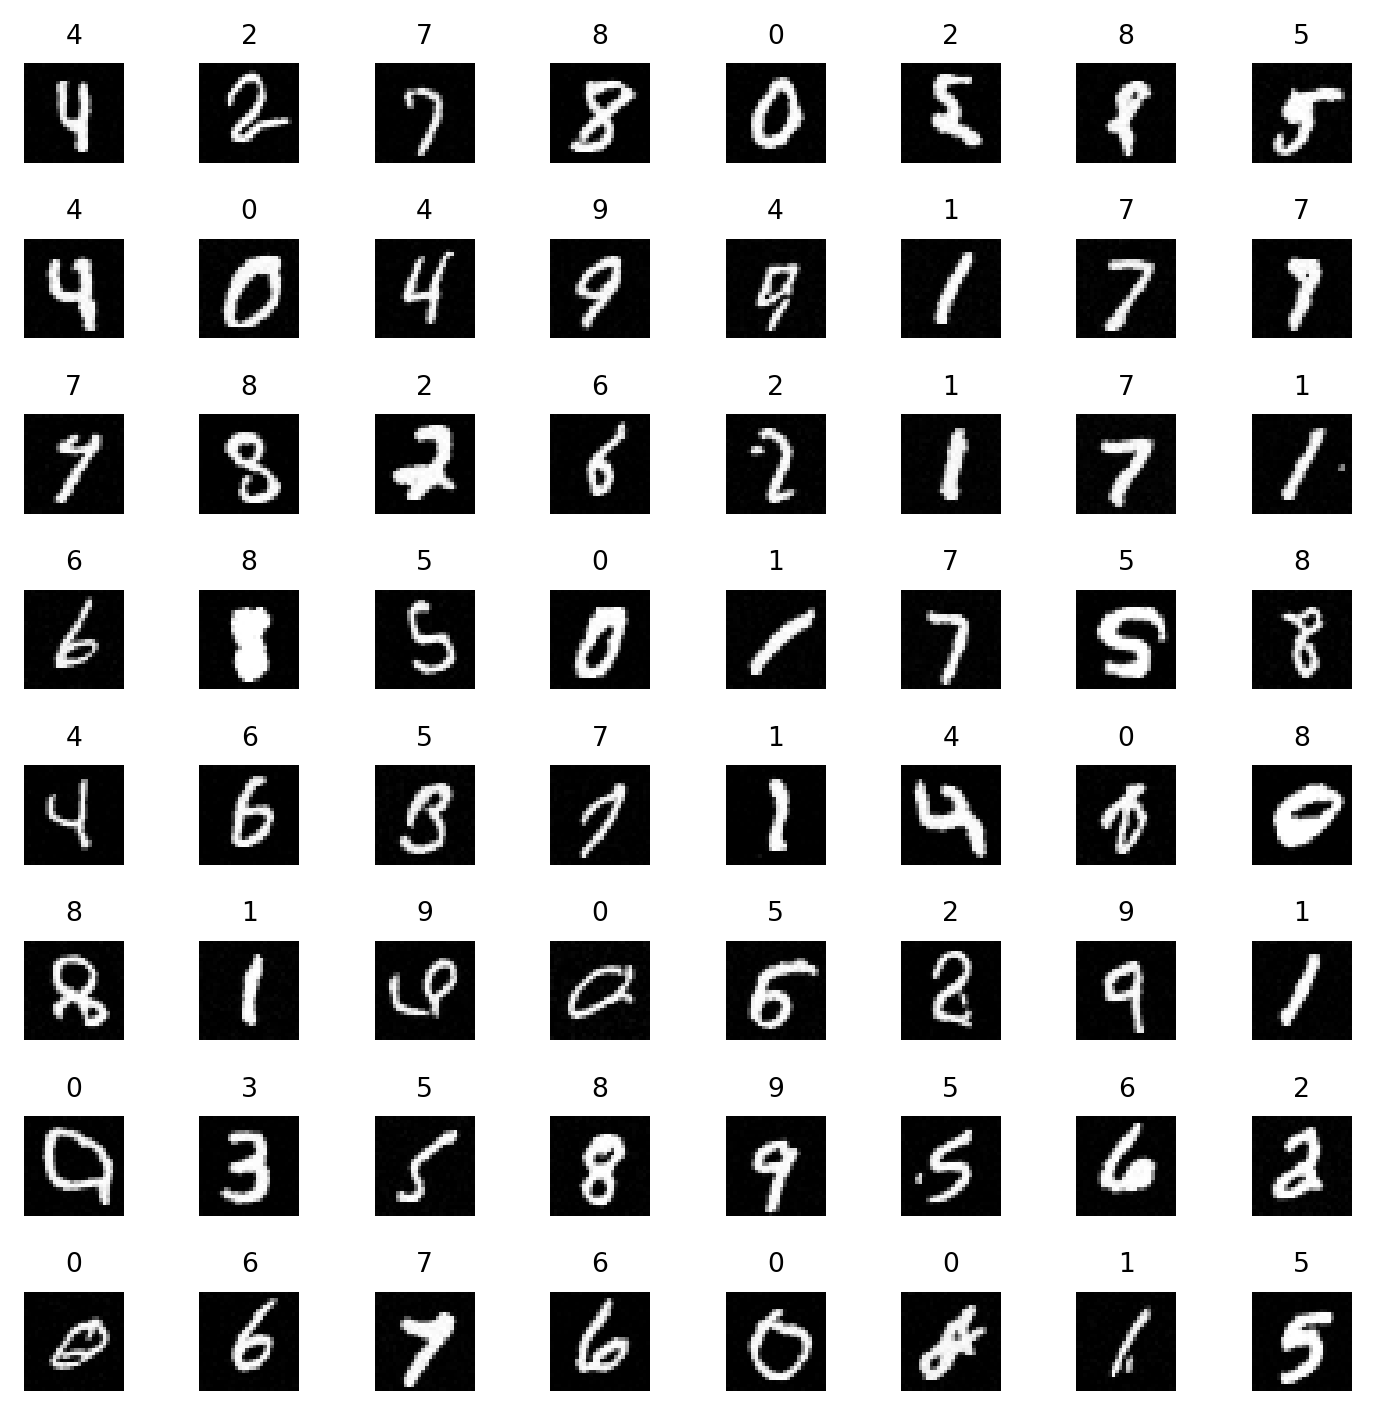

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from cnet import Net

sample_batch_size = 64
samples = Euler_Maruyama_sampler(
    score_model,
    marginal_prob_std_fn,
    diffusion_coeff_fn,
    batch_size=sample_batch_size,
    num_steps=500,
    device='cuda',
    eps=1e-3
)

samples = samples.clamp(0.0, 1.0)



model = Net().to(device)
model.load_state_dict(torch.load('./cnet.pt'))
model.eval()
with torch.no_grad():
    logits = model(samples.to(device))      # (B, num_classes)
    preds = logits.argmax(dim=1).cpu()          # (B,)

B = samples.size(0)
nrow = int(np.sqrt(B))
ncol = int(np.ceil(B / nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i < B:
        img = samples[i].cpu().squeeze(0)       # (H, W) for 1-channel
        ax.imshow(img, cmap='gray', vmin=0., vmax=1.)
        ax.set_title(str(preds[i].item()), fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()